In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import MDAnalysis as mda

from mdvcontainment import Containment
import mdvcontainment.composition_logic as cl

import warnings
warnings.filterwarnings("ignore")

Pywidgets not in current environment, advanced plotting will not work. ($pip install pywidgets).


In [2]:
vmd = "/Applications/VMD\ 1.9.4a57-arm64-Rev12.app/Contents/MacOS/startup.command.csh"

# Loading and voxelizing the PCD

In [3]:
# Systems
settings = {}
settings['complex3D'] = ('../structures/complex3D.gro',  'name True', 1, '', False) # Artificial grid
settings['vesicle'] = ('../structures/vesicle.gro',  'name [CD][234][AB]', 0.5, 'de', False) # CG Martini
settings['transfection'] = ('../structures/transfection.gro',  'name [CD][234][AB]', 0.5, 'de', False) # CG Martini
settings['syn3a'] = ('md_2000ns.gro',  'all', 0.5, 'de', False) # CG Martini

# Settings
no_mapping = False
betafactors = True
verbose = False
selected_settings = 'syn3a'
gro, selection_string, resolution, morph, slab= settings[selected_settings]

In [4]:
u = mda.Universe(gro)
selection = u.select_atoms(selection_string)

# Running an example

In [5]:
# Running the containment calculation
containment = Containment(
    selection, resolution=resolution, morph=morph, 
    slab=slab, max_offset=0.05, write_structures=False, 
    no_mapping=no_mapping, betafactors=betafactors, 
    verbose=verbose)

# Show the containment
print(containment)

Writing component ids in the tempfactors of universe.
Containment Graph with 19 components (component: nm^3: rank):
└── [-18: 5289016: 3]
    └── [1: 649568: 0]
        ├── [-17: 6: 0]
        ├── [-16: 3024353: 0]
        ├── [-15: 3: 0]
        ├── [-14: 6: 0]
        ├── [-13: 10: 0]
        ├── [-12: 3: 0]
        ├── [-11: 6: 0]
        ├── [-2: 6: 0]
        ├── [-9: 3: 0]
        ├── [-8: 7: 0]
        ├── [-7: 3: 0]
        ├── [-6: 3: 0]
        ├── [-5: 3: 0]
        ├── [-4: 3: 0]
        ├── [-3: 6: 0]
        ├── [-1: 3: 0]
        └── [-10: 3: 0]



In [70]:
valid_containment = containment.node_view(min_size=3024353)
print(valid_containment)

Containment Graph with 3 components (component: nm^3: rank):
└── [-18: 5289016: 3]
    └── [1: 649649: 0]
        └── [-16: 3024353: 0]



In [93]:
from mdvcontainment.atomgroup_to_voxels import morph_voxels

In [107]:
outside_mapping = valid_containment.get_original_nodes(-18)
inside_mapping = valid_containment.get_original_nodes(-16)
membrane_mapping = valid_containment.get_original_nodes(1)
# If you ask for voxel positions from a node and you are in a view, will it automatically map to the right nodes?
# This is getting pretty slow... I think I should be using the same format as np.where()
#outside_voxels = valid_containment.voxel_containment.get_voxel_positions(outside_mapping)
#membrane_voxels = valid_containment.voxel_containment.get_voxel_positions(membrane_mapping)
#inside_voxels = valid_containment.voxel_containment.get_voxel_positions(inside_mapping)

In [108]:
inside_voxels_array = np.zeros(valid_containment.voxel_containment.components_grid.shape, dtype=bool)
outside_voxels_array = np.zeros(valid_containment.voxel_containment.components_grid.shape, dtype=bool)
inside_mask = np.isin(valid_containment.voxel_containment.components_grid, inside_mapping)
outside_mask = np.isin(valid_containment.voxel_containment.components_grid, outside_mapping)
inside_voxels_array[inside_mask] = 1
outside_voxels_array[outside_mask] = 1

In [109]:
inside_voxels_array = morph_voxels(inside_voxels_array, 'dddddd') # dilates in place
outside_voxels_array = morph_voxels(outside_voxels_array, 'dddddd') # dilates in place

In [110]:
membrane_voxel_array = inside_voxels_array & outside_voxels_array

In [111]:
trimmed_membrane_atomgroup = valid_containment.get_atomgroup_from_voxel_positions(np.array(np.where(membrane_voxel_array)).T)
print(trimmed_membrane_atomgroup)

<AtomGroup [<Atom 4362164: D2B1 of type B of resname TOCL, resid 202383 and segid SYSTEM>, <Atom 3684682: C1A2 of type C of resname TOCL, resid 172927 and segid SYSTEM>, <Atom 3234948: OH1 of type O of resname SSM, resid 136256 and segid SYSTEM>, ..., <Atom 2702828: R4 of type R of resname CHOL, resid 78602 and segid SYSTEM>, <Atom 2702830: R6 of type R of resname CHOL, resid 78602 and segid SYSTEM>, <Atom 2711429: R1 of type R of resname CHOL, resid 79558 and segid SYSTEM>]>


In [112]:
trimmed_membrane_atomgroup.write('trimmed_membrane.gro')

In [46]:
np.array(np.where(test_voxels_array)).T

array([[  9, 186, 250],
       [  9, 186, 251],
       [  9, 186, 252],
       ...,
       [405, 194, 233],
       [405, 195, 231],
       [405, 195, 232]], shape=(3492786, 3))

In [ ]:
# THIS SHOULD BE THE SAME!!!
#membrane_voxels_with_mapping = valid_containment.voxel_containment.get_voxel_positions(inside_mapping)
#membrane_voxels_without_mapping = valid_containment.voxel_containment.get_voxel_positions([1])

In [22]:
membrane_voxels_with_mapping == membrane_voxels_without_mapping

ValueError: operands could not be broadcast together with shapes (24116952,3) (5180472,3) 

In [19]:
membrane_mapping

[1,
 np.int64(-17),
 np.int64(-15),
 np.int64(-14),
 np.int64(-13),
 np.int64(-12),
 np.int64(-11),
 np.int64(-2),
 np.int64(-9),
 np.int64(-8),
 np.int64(-7),
 np.int64(-6),
 np.int64(-5),
 np.int64(-4),
 np.int64(-3),
 np.int64(-1),
 np.int64(-10)]

In [ ]:
# Write the processed universe to a pdb. The component labeling
# to the betafactors in PDBs occurs in place. Or is done upon instantiation
# of the Containment object.
#containment.set_betafactors()
containment.universe.atoms.write('components.pdb')

In [ ]:
containment.nodes

In [ ]:
#!{vmd} components.pdb # The components are written to the betafactors

In [ ]:
# We can filter out noise nodes by using their downstream voxel size as a threshold
# A view can be made on a containment to only include a subset of nodes, merging the nodes 
# that are not included into their ancestors.
containment_size_filtered = containment.node_view(min_size=10000)
print(containment_size_filtered)

## Plot the compositions of all components in the Containment(View)
We want to obtain a nice multigraph where the colors are consistent for the labels.

In [ ]:
composition, fig, axs = cl.analyze_composition(containment, mode='names')

In [ ]:
# We can also analyze the compositions of the filtered containment view
composition, fig, axs = cl.analyze_composition(containment_size_filtered, mode='names')

## Performing some hierarchical analysis
The goal is to select a random non_root and non-leaf container if there is one.
This is a rather arbitrary goal, but we hope it illustrates
how one can use a topological description to handle high
throughput data with noise. Quickly filtering interesting cases
which can be processed with more attention.

In [58]:
# Preparing the node sets for our selection
all_nodes = set(containment.voxel_containment.nodes)
root_nodes = set(containment.voxel_containment.root_nodes)
leaf_nodes = set(containment.voxel_containment.leaf_nodes)

# Select non-root and non-leaf nodes
container_nodes = list(all_nodes ^ (root_nodes | leaf_nodes))
# Shuffle the possible nodes for random selection
random.shuffle(container_nodes)
# Pick the first node in the shuffle list of possible container nodes
try:
    node = container_nodes[0]
    print(f'Selected non-root container: {node}')
except IndexError:
    print('No component satisfies the specified conditions.')

Selected non-root container: 1


In [59]:
# Get the atomgroup from the list of nodes.
visualize = False
if node is not None:
    container = containment.get_atomgroup_from_nodes([node], containment=True)
    print(f'Atomgroup with {len(container)} atoms.')
    # Write the atomgroup
    container.write('random_container.pdb')
    # Visualize with VMD
    if visualize:
        !{vmd} random_container.gro
else:
    raise ValueError('There are no non-root containers in the system.')

Atomgroup with 6733164 atoms.


### Plotting the composition of the container and its contents
#### Counting the resnames in the atomgroup.atoms

In [60]:
# Make another view to only get the nodes downstream of the selected node
containment_nonroot_container = containment.node_view([node])
nodes = [node]

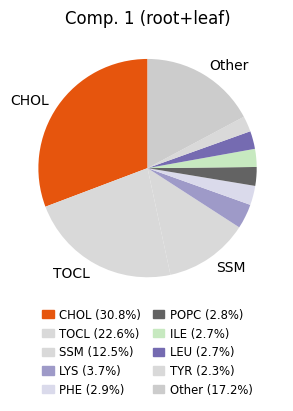

In [70]:
composition, fig, axs = cl.analyze_composition(containment_nonroot_container, mode='resnames')

#### Counting the names in the atomgroup.atoms

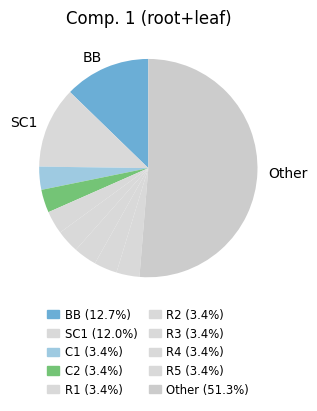

In [62]:
composition, fig, axs = cl.analyze_composition(containment_nonroot_container, mode='names')

## Demonstrating the power of views!
Views are a powerful way in which one can work with containment. You can make a view by using `(Voxel)Containment.node_view([nodes], min_size=0)`. A view will rebuild the non_label_contact_graph, component_contact_graph and containment_graph by merging all nodes not specified upstream. No copies of the memory intensive arrays are made, but they are indexed in a remapped fashion. This makes it easy for a user to work with a reduced version of the contact graph. 

Nearly all methods for the original (Voxel)Containment and their Views are identical, except for some very specific one such as: `VoxelContainmentView.get_original_nodes(self, view_node)` and `VoxelContainmentView.get_view_node(self, original_node)` which indicate which view nodes where mapped to which original nodes.

In [63]:
print(containment.get_atomgroup_from_nodes([node]).__repr__())
print(containment)

print(containment_nonroot_container.get_atomgroup_from_nodes([node]).__repr__())
print(containment_nonroot_container)

original_nodes = [int(sub_node) for sub_node in containment_nonroot_container.voxel_containment.get_original_nodes(node)]
print(f'Original nodes merged into node {node}: {original_nodes}')

<AtomGroup with 6733164 atoms>
Containment Graph with 19 components (component: nm^3: rank):
└── [-18: 5289016: 3]
    └── [1: 649568: 0]
        ├── [-17: 6: 0]
        ├── [-16: 3024353: 0]
        ├── [-15: 3: 0]
        ├── [-14: 6: 0]
        ├── [-13: 10: 0]
        ├── [-12: 3: 0]
        ├── [-11: 6: 0]
        ├── [-2: 6: 0]
        ├── [-9: 3: 0]
        ├── [-8: 7: 0]
        ├── [-7: 3: 0]
        ├── [-6: 3: 0]
        ├── [-5: 3: 0]
        ├── [-4: 3: 0]
        ├── [-3: 6: 0]
        ├── [-1: 3: 0]
        └── [-10: 3: 0]

<AtomGroup with 6733164 atoms>
Containment Graph with 1 components (component: nm^3: rank):
└── [1: 3674002: 0]

Original nodes merged into node 1: [1, -17, -16, -15, -14, -13, -12, -11, -2, -9, -8, -7, -6, -5, -4, -3, -1, -10]


In [64]:
# Show the interactive widget plotting
#cl.show_containment_with_composition(containment, max_display_items=1000, mode='resnames')

In [65]:
containment_view = containment.node_view([-2,1])
print(containment_view)

Containment Graph with 2 components (component: nm^3: rank):
└── [1: 3673996: 0]
    └── [-2: 6: 0]



In [66]:
containment_view_view = containment.node_view([1])
print(containment_view_view)

Containment Graph with 1 components (component: nm^3: rank):
└── [1: 3674002: 0]



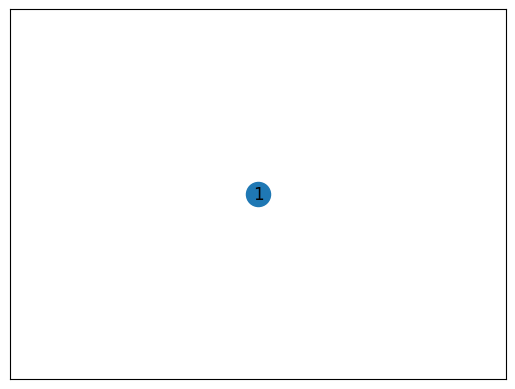

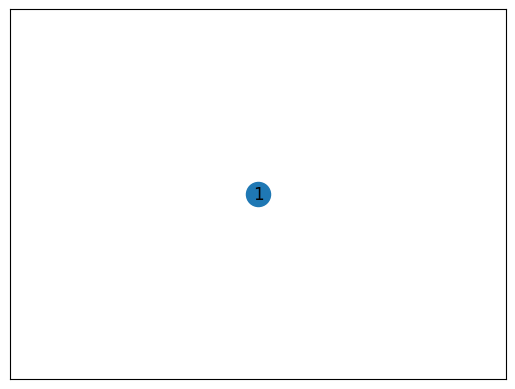

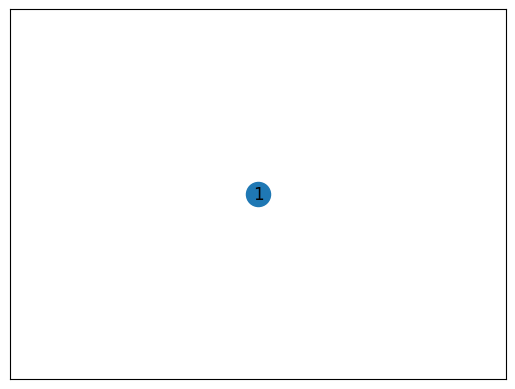

In [67]:
import networkx as nx
nx.draw_networkx(containment_view_view.voxel_containment.nonp_label_contact_graph)
plt.show()
nx.draw_networkx(containment_view_view.voxel_containment.component_contact_graph)
plt.show()
nx.draw_networkx(containment_view_view.voxel_containment.containment_graph)
plt.show()

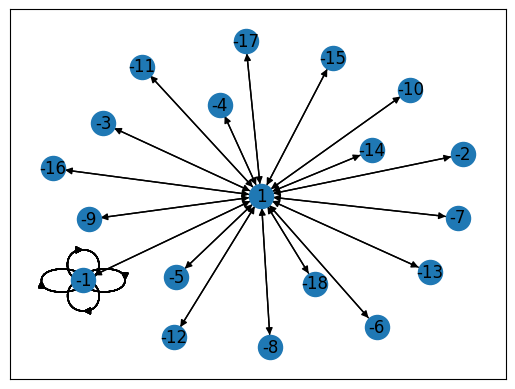

In [68]:
#TODO As we can see the view on the nonp_label_contact graph is not correct, it should have returned {1,2} as these labels together make up component {1}.
# Remember a component is a PBC aware connected blob where, a label is a non-PBC aware connected blob.
nx.draw_networkx(containment.voxel_containment.nonp_label_contact_graph)